In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import selective_destroy
from scipy.optimize import curve_fit

In [2]:
# generating parameters and creating initial state
T1 = 16
T2 = 8
N = 5
dim = 3
trotter_dt = .02
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


# qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
# identity = qt.qeye(dim ** N)

<p align="center"><img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-1-4614-1800-9_152/MediaObjects/978-1-4614-1800-9_152_Fig3_HTML.gif">

In [3]:
Hadamard = qt.Qobj([[1/np.sqrt(2), 0, 1/np.sqrt(2)], [0, 1, 0], [1/np.sqrt(2), 0, -1/np.sqrt(2)]])

mat_cnot1 = np.zeros(shape = (dim ** 2, dim ** 2))
for i in range(dim ** 2):
    for j in range(dim ** 2):
        if i == j and i != 6 and i != 8:
            mat_cnot1[i, j] = 1

mat_cnot1[6, 8] = mat_cnot1[8, 6] = 1
cnot1 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot1), qt.qeye(dim), qt.qeye(dim), qt.qeye(dim)).full())

mat_cnot2 = np.zeros(shape = (dim ** 3, dim ** 3))
for i in range(dim ** 3):
    for j in range(dim ** 3):
        if i == j and i != 18 and i != 20 and i != 21 and i != 23 and i != 24 and i !=26:
            mat_cnot2[i, j] = 1

mat_cnot2[18, 20] = mat_cnot2[20, 18] = mat_cnot2[21, 23] = mat_cnot2[23, 21] = mat_cnot2[24, 26] = mat_cnot2[26, 24] = 1
cnot2 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot2), qt.qeye(dim), qt.qeye(dim)).full())

mat_cnot3 = np.zeros(shape=(dim ** 4, dim ** 4))
for i in range(dim ** 4):
    for j in range(dim ** 4):
        if i == j and i not in [54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80]:
            mat_cnot3[i, j] = 1

mat_cnot3[54, 56] = mat_cnot3[56, 54] = mat_cnot3[57, 59] = mat_cnot3[59, 57] = mat_cnot3[60, 62] = mat_cnot3[62, 60] = mat_cnot3[63, 65] = mat_cnot3[65, 63] = 1
mat_cnot3[66, 68] = mat_cnot3[68, 66] = mat_cnot3[69, 71] = mat_cnot3[71, 69] = mat_cnot3[72, 74] = mat_cnot3[74, 72] = mat_cnot3[75, 77] = mat_cnot3[77, 75] = mat_cnot3[78, 80] = mat_cnot3[80, 78] = 1

cnot3 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot3), qt.qeye(dim)).full())

cnot4 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj(mat_cnot2), qt.qeye(dim)).full())

cnot5 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj(mat_cnot3)).full())

cnot6 = qt.Qobj(qt.tensor(qt.qeye(dim),  qt.qeye(dim), qt.Qobj(mat_cnot2)).full())

# creating the x-gates
x_gate = qt.Qobj([[0, 0, 1], [0, 1, 0],[1, 0, 0]])

z_gate = qt.Qobj([[1, 0, 0], [0, 1, 0], [0, 0, -1]]) 

x_gate_sys = qt.Qobj((qt.tensor(x_gate, x_gate, x_gate, qt.qeye(dim), qt.qeye(dim))).full())

In [4]:
# creating the state pre-noise 
psi0 = qt.tensor(qt.basis(dim, 2), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
rho0 = qt.Qobj((psi0 * psi0.dag()).full())

# creating the initial hadamard gates 
hada_list = qt.Qobj(qt.tensor(Hadamard, Hadamard, Hadamard, qt.qeye(dim), qt.qeye(dim)).full())

rho_encoded = hada_list.dag() * rho0 * hada_list
state_plot = []

# state_plot.append(rho_encoded) # hadamard basis the whole time
state_plot_non_hada = []
# state_plot_non_hada.append(hada_list.dag() * rho_encoded * hada_list)

Try this with a T1 and without a T1

In [5]:
# running the circuit !!

states = [] # saving a list of states as they progress through the circuit 
dur_noise = 0
# noise_introduction = trotter.apply(rho_encoded, duration=dur_noise, discrete_unitary=qt.qeye(dim ** N))
# states.extend(noise_introduction)
# state_plot.extend(noise_introduction)

# state post noise apply the hadamard gates 
# state_pre_drop_down = hada_list.dag() * noise_introduction[-1] * hada_list
state_pre_drop_down = hada_list.dag() * rho_encoded * hada_list
# states.append(state_pre_drop_down)
# state_plot.append(hada_list.dag() * state_pre_drop_down * hada_list)

# applying the x_gates
state_post_decoding = x_gate_sys.dag() * state_pre_drop_down * x_gate_sys
states.append(state_post_decoding)
state_plot.append(hada_list.dag() * state_post_decoding * hada_list)
state_plot_non_hada.append(state_post_decoding)

# applying the set of cnots 
cnot_ordered_gates = cnot6 * cnot5 * cnot4 * cnot3

dur_cnots = 20
state_post_cnot = trotter.apply(state_post_decoding, duration=dur_cnots, discrete_unitary=cnot_ordered_gates)
states.extend(state_post_cnot)
for i in state_post_cnot:
    state_plot.append(hada_list.dag() * i * hada_list)
state_plot_non_hada.extend(state_post_cnot)

# reapply the x_gates
state_post_x_gates = x_gate_sys.dag() * state_post_cnot[-1] * x_gate_sys
# states.append(state_post_x_gates)
# state_plot.append(hada_list.dag() * state_post_x_gates * hada_list)


# re-encoding the state
state_re_encoding = hada_list.dag() * state_post_x_gates * hada_list
states.append(state_re_encoding)
state_plot.append(state_re_encoding)
state_plot_non_hada.append(hada_list.dag() * state_re_encoding * hada_list)

relax_1_dur = 40
relax_1 = trotter.apply(state_re_encoding, duration=relax_1_dur, discrete_unitary=qt.qeye(dim ** N))
states.extend(relax_1)
# for i in relax_1:
#     state_plot.append(hada_list.dag() * i * hada_list)
state_plot.extend(relax_1)
for i in relax_1:
    state_plot_non_hada.append(hada_list.dag() * i * hada_list)
final_state = relax_1[-1]


<p align = "center"> Performing measurement:

In [6]:
projection_op = [qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag()))).full()), 
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag()))).full())
]

In [7]:
# acting with the projection operators on the state
# rho_new = projection_op[0].dag() * final_state * projection_op[0] + projection_op[1].dag() * final_state * projection_op[1] + projection_op[2].dag() * final_state * projection_op[2] + projection_op[3].dag() * final_state * projection_op[3]
rho_1 = qt.tensor(qt.qeye(dim ** N)).dag() * projection_op[0].dag() * final_state * projection_op[0] * qt.tensor(qt.qeye(dim ** N))
rho_2 = qt.Qobj((qt.tensor(z_gate, qt.qeye(dim ** 4)).dag()).full()) * projection_op[1].dag() * final_state * projection_op[1] * qt.Qobj((qt.tensor(z_gate, qt.qeye(dim ** 4))).full())
rho_3 = qt.Qobj((qt.tensor(qt.qeye(dim), z_gate, qt.qeye(dim ** 3)).dag()).full()) * projection_op[2].dag() * final_state * projection_op[2] * qt.Qobj((qt.tensor(qt.qeye(dim), z_gate, qt.qeye(dim ** 3))).full())
rho_4 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), z_gate, qt.qeye(dim ** 2)).dag()).full()) * projection_op[3].dag() * final_state * projection_op[3] * qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), z_gate, qt.qeye(dim ** 2))).full())
rho_new = rho_1 + rho_2 + rho_3 + rho_4
rho_new = rho_new / np.abs(np.trace(rho_new.full()))
# rho_new = rho_4
# states.append(rho_new) # seems like this was doubled down later
# state_plot.append(rho_new) # this should be rho 

check the projection operator on paper and make sure that it makes sense

In [8]:
np.trace((rho_new).full())

(1-1.9182028412955005e-18j)

In [9]:
decoded_state = hada_list.dag() * rho_new * hada_list 
states.append(decoded_state)
state_plot.append(rho_new) # this seems like it was done before may have to remove this 
state_plot_non_hada.append(decoded_state)

In [10]:
# add a relaxation period to see what it looks like 
dur_relax = 500

relaxation = trotter.apply(decoded_state, duration=dur_relax, discrete_unitary=qt.qeye(dim ** N))
states.extend(relaxation)
for i in relaxation:
    state_plot.append(hada_list.dag() * i * hada_list)
# state_plot.extend(relaxation)
state_plot_non_hada.extend(relaxation)

# fixing the states non-hadamard




<p align = "center">Plotting the results(need to put these in the useful presentation states based on what i find out about measurement try to pull out all of the states that have the ancillas)

For this to be more obvious I may have to change back into the 1 and 0 basis which basically means just act with another hadamard at the end in order to make this visible to us 

In [11]:
# list of time steps 
time_list = np.linspace(0, (dur_noise + dur_cnots + dur_relax + relax_1_dur), len(states))
time_list1 = np.linspace(0, (dur_noise + dur_cnots + dur_relax + relax_1_dur), len(state_plot))
time_list2 = np.linspace(0, (dur_noise + dur_cnots + dur_relax + relax_1_dur), len(state_plot_non_hada))

Text(0.5, 1.0, 'Population vs time |+>, |->')

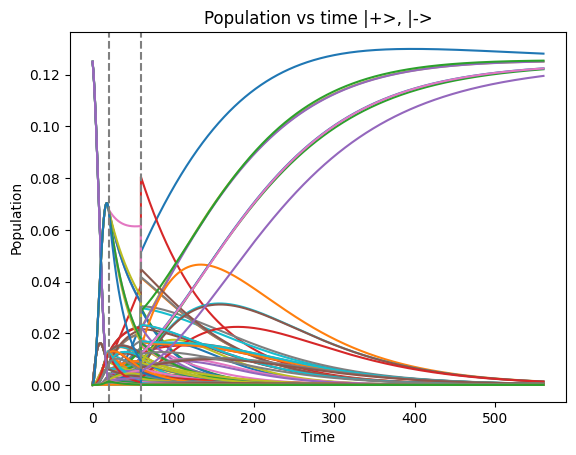

In [36]:
# label these plots with the states
fig, ax = plt.subplots()
for i in range(dim ** N):
    datas = []
    for j in range(len(state_plot)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(state_plot[j][i][i]))     
    ax.plot(time_list1, datas)
ax.axvline(x=20, color="gray", linestyle = "--")
ax.axvline(x=60, color="gray", linestyle = "--")
# ax.axvline(x=340, color="gray", linestyle = "--")
# ax.axvline(x=1040, color="gray", linestyle = "--")
# datas = []
# for j in range(len(states)): 
#     datas.append(np.real(states[j][0][0]))
# ax.plot(time_list, datas)
# for i in [0, 1, 3, 4, 234, 235, 237, 238, 54, 55, 57, 58, 18, 19, 21, 22, 162, 163, 165, 167]:
#     datas = []
#     for j in range(len(state_plot)):
#         datas.append(np.real(state_plot[j][i][i]))     
#     ax.plot(time_list1, datas)
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Population vs time |+>, |->")

Text(0, 0.5, 'Population')

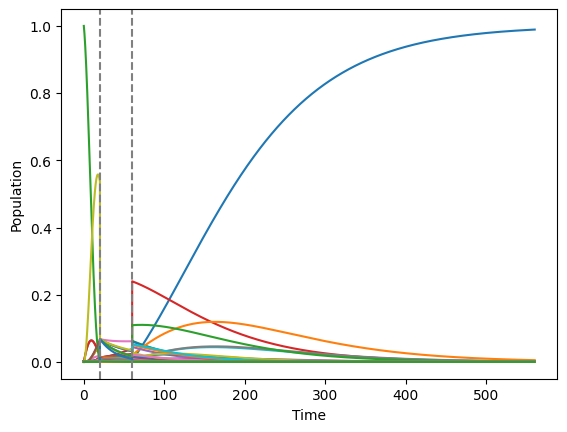

In [37]:
# label these plots with the states
fig, ax = plt.subplots()
for i in range(dim ** N):
    datas = []
    for j in range(len(states)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(states[j][i][i]))     
    ax.plot(time_list, datas)
ax.axvline(x=20, color="gray", linestyle = "--")
ax.axvline(x=60, color="gray", linestyle = "--")
# ax.axvline(x=340, color="gray", linestyle = "--")
# ax.axvline(x=740, color="gray", linestyle = "--")
# datas = []
# for j in range(len(states)): 
#     datas.append(np.real(states[j][0][0]))
# ax.plot(time_list, datas)
# for i in [0, 1, 3, 4, 234, 235, 237, 238, 54, 55, 57, 58, 18, 19, 21, 22, 162, 163, 165, 167, 242, 241, 240]:
#     datas = []
#     for j in range(len(states)):
#         datas.append(np.real(states[j][i][i]))     
#     ax.plot(time_list, datas)
ax.set_xlabel("Time")
ax.set_ylabel("Population")

Text(0.5, 1.0, 'Population vs time |0>, |1>')

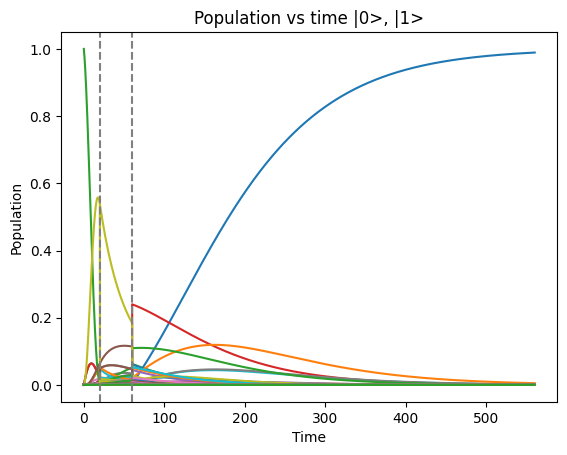

In [38]:
# label these plots with the states
fig, ax = plt.subplots()
for i in range(dim ** N):
    datas = []
    for j in range(len(state_plot_non_hada)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(state_plot_non_hada[j][i][i]))     
    ax.plot(time_list2, datas)
ax.axvline(x=20, color="gray", linestyle = "--")
ax.axvline(x=60, color="gray", linestyle = "--")
# ax.axvline(x=340, color="gray", linestyle = "--")
# for i in [0, 1, 3, 4, 234, 235, 237, 238, 54, 55, 57, 58, 18, 19, 21, 22, 162, 163, 165, 167, 242, 241, 240]:
#     datas = []
#     for j in range(len(state_plot_non_hada)):
#         datas.append(np.real(state_plot_non_hada[j][i][i]))     
#     ax.plot(time_list2, datas)
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Population vs time |0>, |1>")